<a href="https://colab.research.google.com/github/trinade96/Fortiate_Project/blob/master/Fortiate_DST_20_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### **Trina De**

##### In this notebook we will look at Time Series Analysis of Merchant Data. There could be a different approach where we use LSTMs(deep learning) instead.

##### **Packages Installed**

In [1]:
!pip install pyramid_arima

     |████████████████████████████████| 604kB 2.7MB/s 


In [2]:
!pip install arch

     |████████████████████████████████| 716kB 2.8MB/s 


##### **Packages Used**

In [3]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import pyramid
from pyramid.arima import auto_arima
from arch.unitroot import PhillipsPerron
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import kpss
from scipy.stats import kurtosis,skew 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from matplotlib import pyplot
import statsmodels.api as sm
import plotly.graph_objects as go
from arch import arch_model
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyramid/__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision 

##### **Reading the Data**

In [4]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [5]:
merchant_data = pd.read_csv('/gdrive/My Drive/Merchant-Transactions-Jan21.csv')
merchant_data.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.



,MHMID,ORIG_MSG_TYPE,TID,MHPAN,MHTXN_DATE,MHTXN_POST_DATE,MH_POS_TERM_CAPA,MH_POS_ENTRY_MODE,MH_TXN_AMOUNT,AMOUNT,MH_AUTH_CODE,MH_BATCH_NUM,MHGL_TYPE,MHARN_NUM,MHTXN_CURR
0,48845939.0,VISA PLATINUM,9036907,4.760000e+15,11-Feb-19,12-Feb-19,POS ICC,21,20000.0,20000.0,959442,462,8,7.480000e+22,INR
1,48845939.0,VISA PLATINUM,9036907,4.860000e+15,12-Feb-19,12-Feb-19,POS ICC,21,6960.0,6960.0,166833,462,8,7.480000e+22,INR
2,48845939.0,VISA.,9036907,4.170000e+15,12-Feb-19,12-Feb-19,POS ICC,51,27347.0,27347.0,7868,462,10,7.480000e+22,INR
3,48845939.0,MASTERCARD,9036907,5.900000e+15,12-Feb-19,12-Feb-19,POS ICC/MS/KE,51,26843.0,26843.0,194046,462,10,8.520000e+22,INR
4,48845939.0,MC PLATINUM,9036907,5.840000e+15,12-Feb-19,12-Feb-19,POS ICC/MS/KE,21,2057.0,2057.0,226937,462,7,8.520000e+22,INR


In [6]:
merchant_data.shape

(179999, 15)

##### The data is for a total of many categorical. It does not make sense to look at it like one single time series. We will take an example of a single categorical column and then write a code that will do the same for any given categorical column.

##### **Code to find categorical columns in the dataset**

In [0]:
# categorical_cols = []
# for col in merchant_data.columns:
#   if(len(set(merchant_data[col]))<len(merchant_data[col])):
#       categorical_cols = np.append(categorical_cols, col )

# categorical_cols


In [0]:
# len(categorical_cols)


In [7]:
merchant_data.dtypes

MHMID                float64
ORIG_MSG_TYPE         object
TID                   object
MHPAN                float64
MHTXN_DATE            object
MHTXN_POST_DATE       object
MH_POS_TERM_CAPA      object
MH_POS_ENTRY_MODE      int64
MH_TXN_AMOUNT        float64
AMOUNT               float64
MH_AUTH_CODE          object
MH_BATCH_NUM           int64
MHGL_TYPE              int64
MHARN_NUM            float64
MHTXN_CURR            object
dtype: object

##### The reason the above code gives all as categorical is because there are repititions in all the columns, so here we will use the code that makes this judgement on the basis of column data types since that gives a clear distinction between the categorical and non-categorical columns.

In [8]:
categorical_dtype_cols = []
for col in merchant_data.columns:
  if(merchant_data[col].dtype=='object'):
      categorical_dtype_cols = np.append(categorical_dtype_cols, col )

categorical_dtype_cols

array(['ORIG_MSG_TYPE', 'TID', 'MHTXN_DATE', 'MHTXN_POST_DATE',
       'MH_POS_TERM_CAPA', 'MH_AUTH_CODE', 'MHTXN_CURR'], dtype='<U32')

In [9]:
len(categorical_dtype_cols)

7

##### So we will subset the data by one of these 7 columns and perform time series analysis on these individual sections. 'MH_TXN_AMOUNT' is chosen as the column to run time series analysis on.

In [10]:
selected_col = 'TID'
selected_ts = 'MH_TXN_AMOUNT'
selected_set = list(set(merchant_data['TID']))
val = selected_set[1]
df_subset = merchant_data[merchant_data[selected_col]==val]
date = np.arange(1,len(df_subset)+1,1)
## We do not know what the starting date is and so we will forcefully start each time series at 5 years back.
date = pd.to_datetime(date, unit='D',origin=pd.Timestamp('2015-01-01'))
df_subset['Date'] = date
## Now we can pass this dateframe as a valid one for time series analysis
df_subset.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,MHMID,ORIG_MSG_TYPE,TID,MHPAN,MHTXN_DATE,MHTXN_POST_DATE,MH_POS_TERM_CAPA,MH_POS_ENTRY_MODE,MH_TXN_AMOUNT,AMOUNT,MH_AUTH_CODE,MH_BATCH_NUM,MHGL_TYPE,MHARN_NUM,MHTXN_CURR,Date
139609,48857853.0,MASTERCARD,68577873,5.130000e+15,12-Feb-19,12-Feb-19,POS MS PIN,21,2751.21,2751.21,168912,0,4,8.520000e+22,INR,2015-01-02
139610,48857853.0,MASTERCARD,68577873,5.580000e+15,12-Feb-19,12-Feb-19,POS MS PIN,21,678.10,678.10,0000CB,0,4,8.520000e+22,INR,2015-01-03
139611,48857853.0,VISA PLATINUM,68577873,4.860000e+15,12-Feb-19,12-Feb-19,POS MS NO PIN,21,553.44,553.44,264663,0,8,7.480000e+22,INR,2015-01-04
139612,48857853.0,MC PLATINUM,68577873,5.350000e+15,12-Feb-19,12-Feb-19,POS MS PIN,21,342.15,342.15,13534,0,8,8.520000e+22,INR,2015-01-05
139613,48857853.0,MC PLATINUM,68577873,5.350000e+15,12-Feb-19,12-Feb-19,POS MS PIN,21,490.34,490.34,14229,0,8,8.520000e+22,INR,2015-01-06


##### It is very much possible that there are some 'TID' categories that correspond to very few rows in which case it is not at all possible to predict on the basis of it. So we will be applying a check here. If the number of data points is at least 250 we will say that we can predict the next k values or else we will say that we have insufficient data and we stop with our effort of predictions there. Applying this quick check for the categories of 'TID'.

In [0]:
## Function that tells you if you have enough data to predict or not
def data_sufficed(df):
  if(len(df)>=500):
    return True
  else:
    return False

In [12]:
data_sufficed_val = []
start = time.time()
for val in selected_set:
  df_temp = merchant_data[merchant_data[selected_col]==val]
  if(data_sufficed(df_temp)==True):
    data_sufficed_val = np.append(data_sufficed_val,val)

end= time.time()
print('Time taken for finding data sufficient columns is:{}'.format(end-start))

Time taken for finding data sufficient columns is:88.60473561286926


In [13]:
print(len(data_sufficed_val))
print(len(selected_set))

23
7937


##### So from now on we will be able to predict for only values of 'TID' in these 23 values that are there. we have been able to avoid looking at all 7937 values of 'TID' for predictions.

##### **EXAMPLE 1**

In [14]:
selected_val = data_sufficed_val[0]
df_subset_final = merchant_data[merchant_data[selected_col]==float(selected_val)]
len(df_subset_final)

2079

In [15]:
print(df_subset_final['MH_TXN_AMOUNT'].describe())

count     2079.000000
mean       689.062530
std       1014.757367
min        100.000000
25%        240.000000
50%        350.000000
75%        550.000000
max      12500.000000
Name: MH_TXN_AMOUNT, dtype: float64


In [16]:
date  = np.arange(1,len(df_subset_final)+1,1)
date = pd.to_datetime(date,unit='D',origin=pd.Timestamp('2015-01-01'))
df_subset_final['Date']=date

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



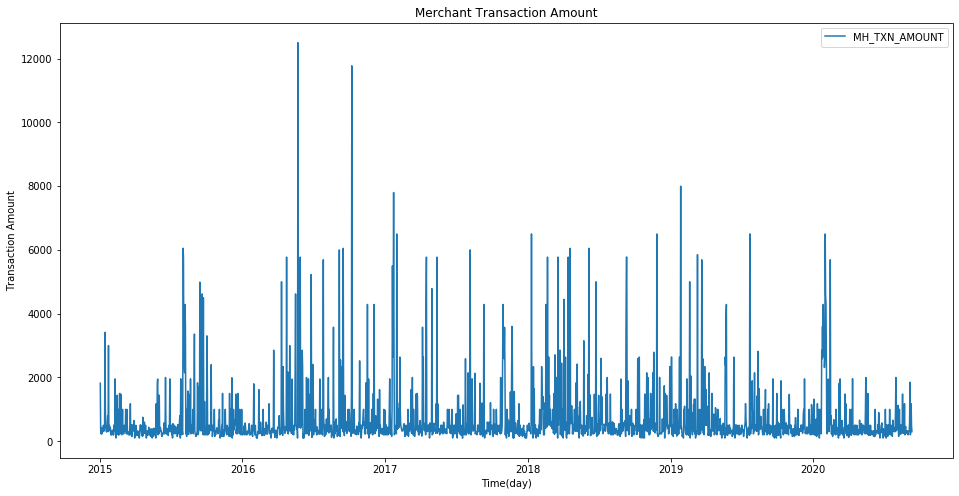

In [17]:
df_subset_final.index = df_subset_final['Date'] # indexing the Datetime to get the time period on the x-axis.
ts = df_subset_final['MH_TXN_AMOUNT']
plt.figure(figsize=(16,8))
plt.plot(ts, label='MH_TXN_AMOUNT')
plt.title('Merchant Transaction Amount')
plt.xlabel("Time(day)")
plt.ylabel("Transaction Amount")
plt.legend(loc='best')

##### So this is what the data looks like. Our next first step is to check that the data is stationary because if it isn't it is useless to try to forecast for such a series.

## ADF TEST

### Here the alternate hypothesis: Data is Stationary

In [0]:
def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [19]:
test_stationarity(df_subset_final['MH_TXN_AMOUNT'])

Test Statistic                -1.452729e+01
p-value                        5.402379e-27
#Lags Used                     5.000000e+00
Number of Observations Used    2.073000e+03
Critical Value (1%)           -3.433508e+00
Critical Value (5%)           -2.862935e+00
Critical Value (10%)          -2.567513e+00
dtype: float64


##### Therefore we reject the null hypothesis and accept the alternative hypothesis that the data is stattionary. We will perform two more similar tests just to be sure of the result.

## KPSS TEST

### Here the alternate hypothesis is the series is not stationary.

In [0]:
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)' %key] = value
    print(kpss_output)

In [21]:
kpss_test(df_subset_final['MH_TXN_AMOUNT'])

Results of KPSS Test:
Test Statistic            0.168575
p-value                   0.100000
Lags Used                26.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value



### Here at 5% level of significance we accept the null hypothesis i.e the data is stationary.



In [22]:
pp = PhillipsPerron(df_subset_final['MH_TXN_AMOUNT'])
print(pp.summary())

     Phillips-Perron Test (Z-tau)    
Test Statistic                -42.010
P-value                         0.000
Lags                               26
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


##### Therefore all the 3 tests come to the same conclusion that the process is stationary.

##### Since the original data is already stationary we can directly start to apply ARIMA models on that without making any transformations. But to get a better idea about the orders of ARIMA we shall plot the ACF and the PACF of the data. 

##### ***Identification of an AR model is often best done with the PACF.***

For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model” we mean the most extreme lag of x that is used as a predictor.

... a kth order autoregression, written as AR(k), is a multiple linear regression in which the value of the series at any time t is a (linear) function of the values at times $t−1,t−2,…,t−k:$

##### $y_{t} = β_{0} + β_{1}*y_{t−1} + β_{2}*y_{t−2} + ⋯ + β_{2}y_{t−k} + ϵ_{t}$

________________________________________________________________________________
________________________________________________________________________________


##### ***Identification of an MA model is often best done with the ACF rather than the PACF.***

For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.

A moving average term in a time series model is a past error (multiplied by a coefficient).

The qth-order moving average model, denoted by MA(q) is
##### $x_{t}=μ + w_{t} + θ_{1}*w_{t−1} + θ_{2}*w_{t−2} + ⋯ + θ_{q}*w_{t−q}$
with  $w_{t}∼iid$        $N(0,σ^{2}_{w})$

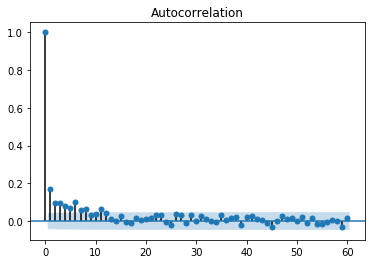

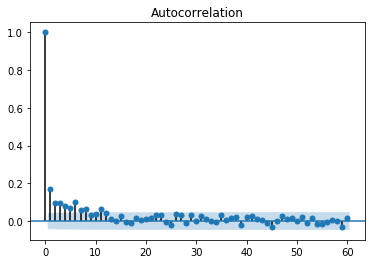

In [23]:
plot_acf(df_subset_final['MH_TXN_AMOUNT'].dropna(),lags = 60)

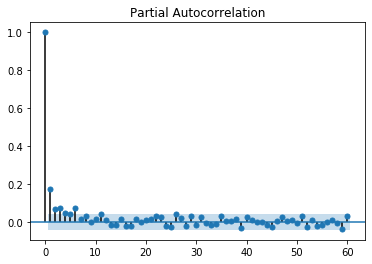

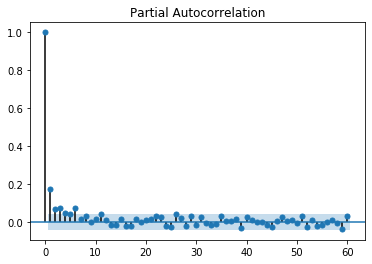

In [24]:
plot_pacf(df_subset_final['MH_TXN_AMOUNT'].dropna(),lags = 60)

##### So from the graphs the data is most proabably ARIMA with p = 5 and q = 4. However these are just intuitions, we still have to find the correct model.

##### **ARIMA Model Fitting**

In [0]:
new_value = pd.Series(df_subset_final['MH_TXN_AMOUNT'][:2071])
new_value.index = df_subset_final.dropna().index[:2071]

In [26]:
model1 = auto_arima(np.array(new_value), start_p=1, start_q=1, start_P=1, start_Q=1,
                  max_p=10, max_q=10, max_P=10, max_Q=10, seasonal=True,
                  stepwise=True, suppress_warnings=True, D=10, max_D=10,
                  error_action='ignore')
model1.fit(np.array(new_value))

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(6, 0, 0),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
      suppress_warnings=True, transparams=True, trend='c')

##### So we get an AR(6) model which is an autoregressive process with order 6. The model that is returned is on the basis of the AIC or Akaike Information Criterion. It minimizes the error whilst penalizing for overfitting.

##### The formula for AIC is given by:
$AIC = -2(log-likelihood) + 2K$
##### where K is the number of parameters in the model. The model with the minimum AIC gets picked.

In [0]:
forecast = model1.predict(n_periods = 8)
test = df_subset_final['MH_TXN_AMOUNT'][2071:]

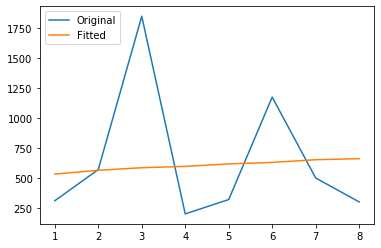

In [28]:
x = np.arange(1,9)
plt.plot(x, test)
plt.plot(x, forecast)
plt.legend(['Original', 'Fitted'], loc='upper left')
plt.show()

##### So we see that the fitted model does not do well past the first 2 datapoints which is as expected with any real life data. We are still not done here. We need to check for heteroscedasticity in the data and find a way to account for it.

##### **Residuals and Ljung Box Test**

##### **Box-Ljung Test**
Test for Lack of Fit	The Box-Ljung test (1978) is a diagnostic tool used to test the lack of fit of a time series model
The test is applied to the residuals of a time series after fitting an ARMA(p,q) model to the data. The test examines m autocorrelations of the residuals. If the autocorrelations are very small, we conclude that the model does not exhibit significant lack of fit.


##### Definition	In general, the Box-Ljung test is defined as:
>H0:	The model does not exhibit lack of fit.

>Ha:	The model exhibits lack of fit.

>Test Statistic:	Given a time series Y of length n, the test statistic is defined as:
### $Q=n(n+2)∑_{k=1}^{m}\frac{r^{2}_{k}}{n−k}$

##### where $r^{k}$ is the estimated autocorrelation of the series at lag k, and m is the number of lags being tested.

>Significance Level:	α

>Critical Region:	The Box-Ljung test rejects the null hypothesis (indicating that the model has significant lack of fit) if
##### $Q>χ^{2}_{1−α,h}$
where $χ^{2}_{1−α,h}$ is the chi-square distribution table value with h degrees of freedom and significance level α.
##### Because the test is applied to residuals, the degrees of freedom must account for the estimated model parameters so that h=m−p−q, where p and q indicate the number of parameters from the ARMA(p,q) model fit to the data.

##### **Performing the test**

In [29]:
fitted_values = model1.predict_in_sample(start=0, end=2070)
residuals = new_value - fitted_values
residuals_squared = [i*i for i in residuals]
len(residuals_squared)

2071

In [30]:
x = np.arange(1,2071)
fig = go.Figure(data=go.Scatter(x = x, y = residuals_squared))
fig.show()

##### The residuals seem to be on mostly on the positive side of the x axis which means that the ARIMA model consistently underestimates the actual value. It could be due to the fact that we are missing a component which could be countered by taking heteroscedastic errors into account. To be sure we will perform the Ljung-Box Test now.

### Ljung Box test

In [0]:
nlags = 150
results_resi = sm.stats.diagnostic.acorr_ljungbox(residuals, nlags)

In [32]:
x_axis = np.arange(1,21)
fig = go.Figure(data=go.Scatter(x = x_axis, y = results_resi[1]))
fig.show()

##### Therefore the p-value of the test next in the observed range goes below the critical value which is 0.05. So we can assume that the data does not have heteroscedasticity in it. So our forecasts from the ARIMA model will have to suffice and that it is good for now only two time periods ahead of the latest value in the time series.

##### **EXAMPLE 2**
##### **Taking another time series to experiment on, hopefully to display GARCH and ARCH fitting techniques on it**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



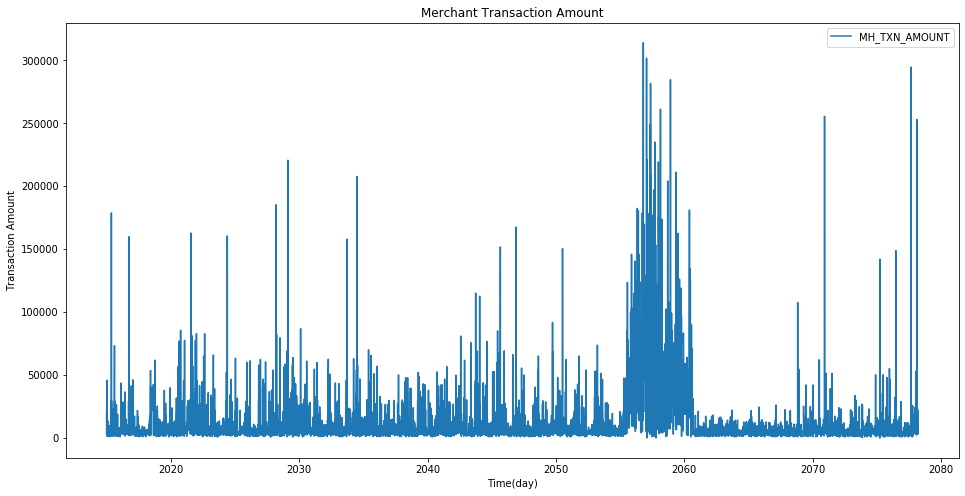

In [34]:
selected_val = data_sufficed_val[22]
df_subset_final = merchant_data[merchant_data[selected_col]==selected_val]

date  = np.arange(1,len(df_subset_final)+1,1)
date = pd.to_datetime(date,unit='D',origin=pd.Timestamp('2015-01-01'))
df_subset_final['Date']=date

df_subset_final.index = df_subset_final['Date'] # indexing the Datetime to get the time period on the x-axis.
ts = df_subset_final['MH_TXN_AMOUNT']
plt.figure(figsize=(16,8))
plt.plot(ts, label='MH_TXN_AMOUNT')
plt.title('Merchant Transaction Amount')
plt.xlabel("Time(day)")
plt.ylabel("Transaction Amount")
plt.legend(loc='best')

In [35]:
test_stationarity(df_subset_final['MH_TXN_AMOUNT'])


Test Statistic                -8.102975e+00
p-value                        1.284996e-12
#Lags Used                     4.700000e+01
Number of Observations Used    2.303900e+04
Critical Value (1%)           -3.430634e+00
Critical Value (5%)           -2.861665e+00
Critical Value (10%)          -2.566837e+00
dtype: float64


In [36]:
kpss_test(df_subset_final['MH_TXN_AMOUNT'])


Results of KPSS Test:
Test Statistic            2.255001
p-value                   0.010000
Lags Used                47.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value



In [37]:
pp = PhillipsPerron(df_subset_final['MH_TXN_AMOUNT'])
print(pp.summary())

     Phillips-Perron Test (Z-tau)    
Test Statistic               -116.011
P-value                         0.000
Lags                               47
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


##### So we have a couple of tests that tells us that the data is stationary and other one telling us that it is not. It happens sometimes because of the different test statistics that are being used in the tests. To be on the safe side we can just **once difference** the data and see if that renders it stationary.

In [0]:
## Here selected_ts is "MH_TXN_AMOUNT"
original_diff = df_subset_final[selected_ts] - df_subset_final[selected_ts].shift(1)

In [39]:
test_stationarity(original_diff.dropna())

Test Statistic                   -35.135051
p-value                            0.000000
#Lags Used                        47.000000
Number of Observations Used    23038.000000
Critical Value (1%)               -3.430634
Critical Value (5%)               -2.861665
Critical Value (10%)              -2.566837
dtype: float64


In [40]:
kpss_test(original_diff.dropna())

Results of KPSS Test:
Test Statistic            0.001807
p-value                   0.100000
Lags Used                47.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value



In [41]:
pp = PhillipsPerron(original_diff.dropna())
print(pp.summary())

     Phillips-Perron Test (Z-tau)    
Test Statistic               -585.566
P-value                         0.000
Lags                               47
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


##### Now we have a consensus that the data is stationary from all the three tests.

##### Plotting ACF and PACF

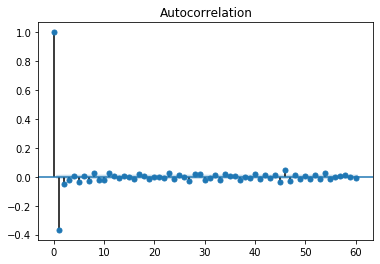

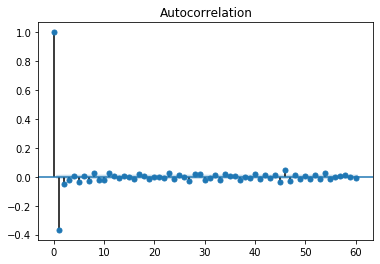

In [42]:
plot_acf(original_diff.dropna(),lags = 60)

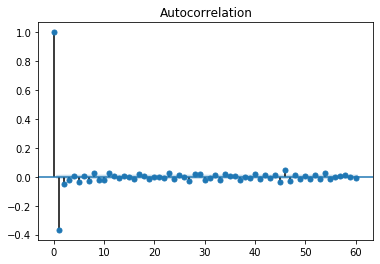

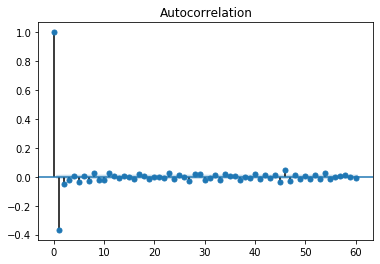

In [43]:
plot_acf(original_diff.dropna(),lags = 60)

In [0]:
# diff_df = pd.DataFrame(original_diff.dropna())
# diff_df.columns = ['Differenced_data']
new_value = pd.Series(original_diff.dropna()[:len(original_diff.dropna())-8])
new_value.index = original_diff.dropna().index[:len(original_diff.dropna())-8]

In [0]:
start = time.time()
model1 = auto_arima(np.array(new_value), start_p=1, start_q=1, start_P=1, start_Q=1,
                  max_p=10, max_q=10, max_P=10, max_Q=10, seasonal=True,
                  stepwise=True, suppress_warnings=True, D=10, max_D=10,
                  error_action='ignore')
model1.fit(np.array(new_value))
end = time.time()


In [63]:
print('Time taken to fit the ARIMA model is:{}'.format(end-start))

Time taken to fit the ARIMA model is:758.9296426773071


##### The reason why it takes some time here is because of the length of the data which is more than 10 times of the previous data, at 23078 rows.

In [0]:
forecast = model1.predict(n_periods = 8)

In [0]:
## test = df_subset_final[selected_ts][len(original_diff).dropna())-7:]
for i in range(len(forecast)):
    if i == 0:
        forecast[i] += df_subset_final[selected_ts][len(original_diff.dropna())-8]
    else:
        forecast[i] += forecast[i-1]

In [0]:
test = df_subset_final[selected_ts][len(original_diff.dropna())-7:]

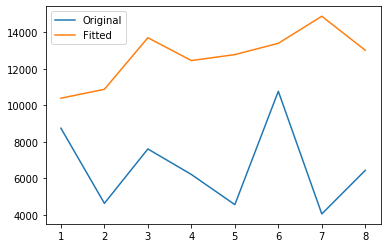

In [67]:
x = np.arange(1,9)
plt.plot(x, test)
plt.plot(x, forecast)
plt.legend(['Original', 'Fitted'], loc='upper left')
plt.show()

##### There is a consistent overestimation in the fitted values. It could be because of a consistent part that we are missing. We will once again try to check for heteroscedasticity of errors by the Ljung-Box test.

In [68]:
fitted_values = model1.predict_in_sample(start=0, end=len(original_diff.dropna())-9)

residuals = new_value - fitted_values
residuals_squared = [i*i for i in residuals]

x = np.arange(1,len(original_diff.dropna())-7)
fig = go.Figure(data=go.Scatter(x = x, y = residuals_squared))
fig.show()

In [70]:
nlags = 100
results_resi2 = sm.stats.diagnostic.acorr_ljungbox(residuals_squared, nlags)
x_axis = np.arange(1,101)
fig = go.Figure(data=go.Scatter(x = x_axis, y = results_resi2[1]))
fig.show()

##### So the data residuals are strongly autocorrelated. To fix this we must do GARCH fitting on this,ARIMA is no longer enough.

## Fitting Garch Model

In [71]:
model2 = auto_arima(residuals_squared, start_p=1, start_q=1, start_P=1, start_Q=1,
                  max_p=5, max_q=5, max_P=5, max_Q=5, seasonal=True,
                  stepwise=True, suppress_warnings=True, D=10, max_D=10,
                  error_action='ignore')
model2.fit(residuals_squared)

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(4, 1, 4),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
      suppress_warnings=True, transparams=True, trend='c')

In [76]:
print(model2.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                23078
Model:               SARIMAX(4, 1, 4)   Log Likelihood             -520285.612
Date:                Sat, 01 Feb 2020   AIC                        1040591.224
Time:                        06:57:22   BIC                        1040671.690
Sample:                             0   HQIC                       1040617.368
                              - 23078                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.796e+04   1.32e-06  -2.87e+10      0.000    -3.8e+04    -3.8e+04
ar.L1         -0.6962      0.300     -2.324      0.020      -1.283      -0.109
ar.L2          0.7783      0.025     31.547      0.0

In [77]:
lag_residual_sqr = pd.Series(residuals_squared) - pd.Series(residuals_squared).shift(1)
lag_residual_sqr = lag_residual_sqr.dropna()

fig = go.Figure(data=go.Scatter(x = np.arange(1,len(original_diff.dropna())-8), y = list(lag_residual_sqr)))
fig.show()

In [74]:
test_stationarity(lag_residual_sqr)

Test Statistic                   -36.555551
p-value                            0.000000
#Lags Used                        46.000000
Number of Observations Used    23030.000000
Critical Value (1%)               -3.430634
Critical Value (5%)               -2.861666
Critical Value (10%)              -2.566837
dtype: float64


In [75]:
kpss_test(lag_residual_sqr)

Results of KPSS Test:
Test Statistic            0.001081
p-value                   0.100000
Lags Used                47.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value



In [78]:
pp = PhillipsPerron(lag_residual_sqr)
print(pp.summary())

     Phillips-Perron Test (Z-tau)    
Test Statistic               -849.346
P-value                         0.000
Lags                               47
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


##### So lag_residual_squared is stationary

In [79]:
garch11 = arch_model(new_value, p=4, q=4)
garch11_fit = garch11.fit()

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.068e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




Iteration:      1,   Func. Count:     12,   Neg. LLF: 242635.1234887781
Iteration:      2,   Func. Count:     25,   Neg. LLF: 241894.9096021234
Iteration:      3,   Func. Count:     39,   Neg. LLF: 241869.037588522
Iteration:      4,   Func. Count:     52,   Neg. LLF: 241688.11133083986
Iteration:      5,   Func. Count:     64,   Neg. LLF: 241009.8887156976
Iteration:      6,   Func. Count:     77,   Neg. LLF: 241010.5974852952
Iteration:      7,   Func. Count:     91,   Neg. LLF: 241002.94143859396
Iteration:      8,   Func. Count:    104,   Neg. LLF: 241007.34635333956
Iteration:      9,   Func. Count:    126,   Neg. LLF: 241007.35030583048
Iteration:     10,   Func. Count:    148,   Neg. LLF: 241007.13560364762
Iteration:     11,   Func. Count:    162,   Neg. LLF: 241007.87771281478
Iteration:     12,   Func. Count:    174,   Neg. LLF: 241043.11651330258
Iteration:     13,   Func. Count:    186,   Neg. LLF: 241042.62372587153
Iteration:     14,   Func. Count:    198,   Neg. LLF: 241

In [80]:
garch11_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:          MH_TXN_AMOUNT   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -240996.
Distribution:                  Normal   AIC:                           482011.
Method:            Maximum Likelihood   BIC:                           482092.
                                        No. Observations:                23078
Date:                Sat, Feb 01 2020   Df Residuals:                    23068
Time:                        07:01:39   Df Model:                           10
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu           360.4442    176.021      2.048  4.059e-02 [ 15.448,7.054e+02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.1347e+06  2.273e+06      1.819  6.885e-02 [-3.194e+05,8.589e+06]
alpha[1]       0.2275  3.917e-02      5.809  6.299e-09      [  0.151,  0.304]
alpha[2]   2.1701e-08  6.232e-02  3.482e-07      1.000      [ -0.122,  0.122]
alpha[3]   4.4619e-14      0.163  2.729e-13      1.000      [ -0.320,  0.320]
alpha[4]   4.2352e-14  6.865e-02  6.169e-13      1.000      [ -0.135,  0.135]
beta[1]        0.6328      0.240      2.634  8.442e-03      [  0.162,  1.104]
beta[2]    2.3098e-08      0.778  2.970e-08      1.000      [ -1.524,  1.524]
beta[3]    5.8360e-08      0.743  7.857e-08      1.000      [ -1.456,  1.456]
beta[4]        0.1397      0.238      0.588      0.557      [ -0.326,  0.605]
=============================================================================

Covariance estimator: robust
"""

In [0]:
garch_forecast = garch11_fit.forecast(start = 0,horizon = 8)

In [82]:
original_diff.index[len(original_diff.dropna())-8]

Timestamp('2078-03-11 00:00:00')

In [0]:
expected_error_sqr = list(garch_forecast.variance.loc[original_diff.index[len(original_diff.dropna())-8]])

In [86]:
expected_error_sqr

[246944446.61323094,
 273847324.04336756,
 287068576.6590415,
 291585667.00507027,
 289484995.11677355,
 291435537.90734065,
 294960373.2004148,
 298623807.0760791]

In [0]:
expected_error = [np.sqrt(i) for i in expected_error_sqr]

In [0]:
a = np.random.normal(0,1,8)
#a = [np.sign(i) for i in a]

In [0]:
estimated_error = np.multiply(expected_error,a)

In [0]:
garch_forecast = list(map(np.add,forecast,estimated_error))

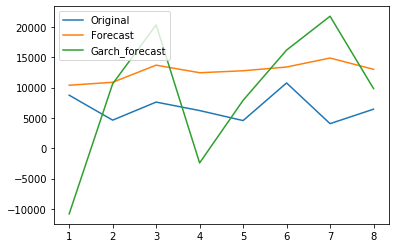

In [95]:
x = np.arange(1,9)
plt.plot(x, test)
plt.plot(x, forecast)
plt.plot(x,garch_forecast)
plt.legend(['Original', 'Forecast','Garch_forecast'], loc='upper left')
plt.show()

##### So the GARCH forecast does better than the original forecast in this case. But this is not always the case, sometimes it can be worse in which case we have to be careful.

### **ROUGH**

In [0]:
## To show the uncertainity of future estimates of ARIMA modelling

In [0]:
pd.to_datetime([1, 2, 3], unit='D',
...                origin=pd.Timestamp('1960-01-01'))